# Description

Very simple linear regression example with pytorch over the Iris dataset. Which was made to understand some machine learning fundamentals. Some highly convinient features of PyTorch were not used but made from scratch for this specific use-case. In fact all the Pytorch code of this notebook can be easily replaced with numpy.

In this example we will predict the sepal length of the given 3 iris species from one of their other attributes.

# Data Acquisition

In [1]:
import pandas as pd

## Download Iris dataset

In [2]:
iris_url = "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"

In [3]:
df = pd.read_csv(iris_url)

## Replace "." to "_" in column names

In [4]:
df.columns = [c.replace(".", "_") for c in df.columns]
df

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


# Data Exploration

In [5]:
import matplotlib.pyplot as plt

## Scatter plot

From the scatterplot below we can see that sepal length mostly have linear dependence on the petal length feature.

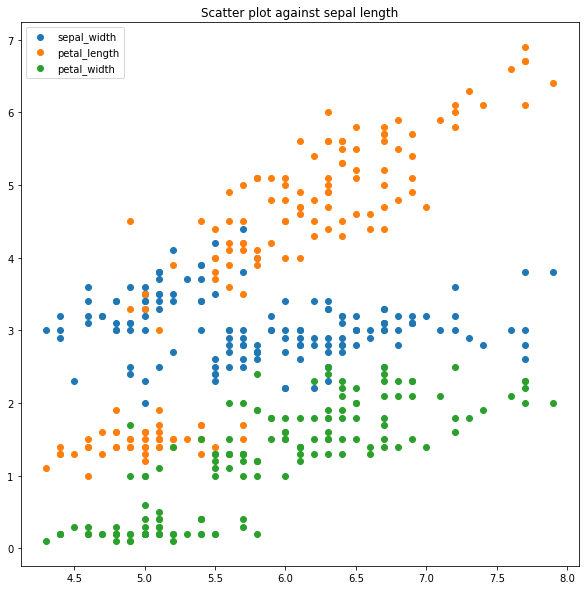

In [6]:
fig = plt.figure(figsize=(10,10))
plt.scatter(
    df["sepal_length"], 
    df["sepal_width"], 
    label="sepal_width"
)
plt.scatter(
    df["sepal_length"], 
    df["petal_length"], 
    label="petal_length"
)
plt.scatter(df["sepal_length"], 
            df["petal_width"], 
            label="petal_width"
)

plt.title('Scatter plot against sepal length')
plt.legend()

# Data preparation 

In [7]:
import numpy as np

## Normalization by mean

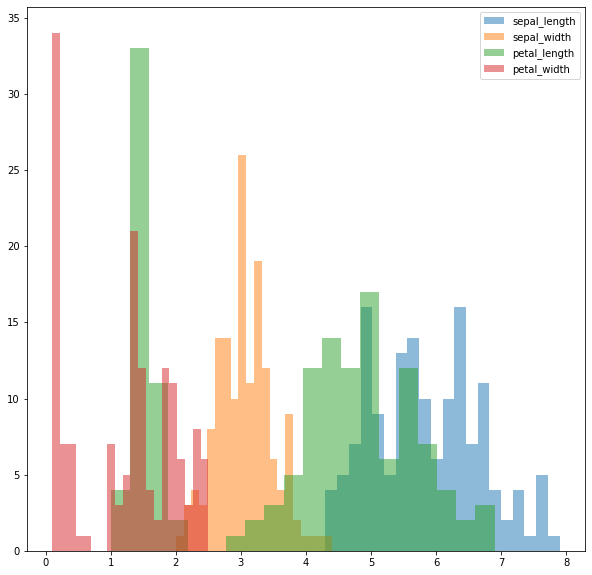

In [8]:
fig = plt.figure(figsize=(10,10))
for i, c in enumerate(df.iloc[:,:4].columns):
    plt.hist(df[c], bins=20, alpha=0.5, label=c)
plt.legend()
    

In [9]:
def normalize(x):
    x_avg = np.average(x)
    x_std = np.std(x)
    return (x - x_avg) / x_std
        

In [10]:
df_train = df.iloc[:,:4].apply(normalize).copy()
df_train

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


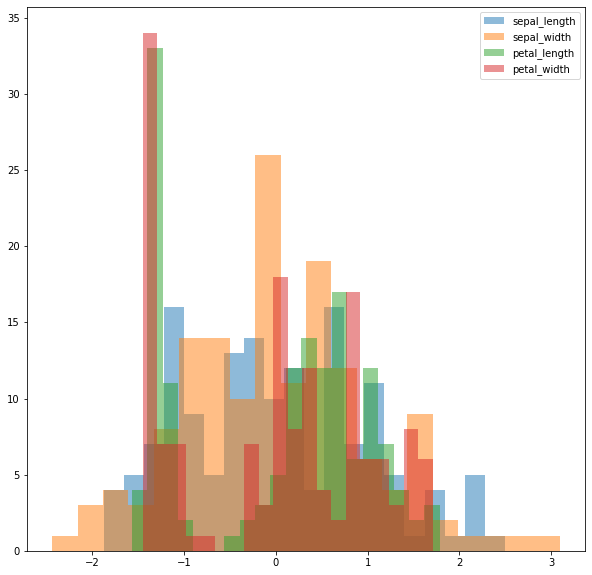

In [11]:
fig = plt.figure(figsize=(10,10))
for i, c in enumerate(df_train.iloc[:,:4].columns):
    plt.hist(df_train[c], bins=20, alpha=0.5, label=c)
plt.legend()
    

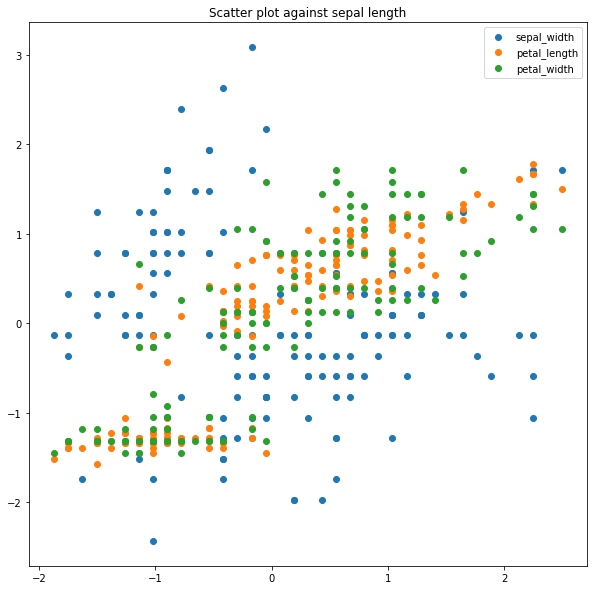

In [12]:
fig = plt.figure(figsize=(10,10))
plt.scatter(
    df_train["sepal_length"], 
    df_train["sepal_width"], 
    label="sepal_width"
)
plt.scatter(
    df_train["sepal_length"], 
    df_train["petal_length"], 
    label="petal_length"
)
plt.scatter(
    df_train["sepal_length"], 
    df_train["petal_width"], 
    label="petal_width"
)

plt.title('Scatter plot against sepal length')
plt.legend()

# Training

In [13]:
import torch

## Model

We assume that sepal length is linearly dependent on petal length. So our model is a simple line defined by two parameters, its slope a.k.a as the weight of the input and intersection of the y axis a.k.a as the bias.

Linear model/function
$$
M = m(x)_{w,b} = wx + b
$$

In [14]:
def model(x, w, b):
    return w*x + b

Input:

- `x` is the input tensor

Output:

- `M` is the output tensor, model prediction

Parameters:

- `w` is the weight parameter
- `b` is the bias parameter

The parameters in this case will be scalars, so 0 dimensional tensors.

The derivates of the model in respect of its parameters:

$$
 \frac {d} {dw} wx + b   = x
$$

$$
 \frac {d} {db} wx + b   = 1
$$

In [15]:
def d_model_dw(x, w, b):
    return x

In [16]:
def d_model_db(x, w, b):
    return 1.0

## Loss function 

Mean Square Loss

$$
L = l(M, T) = \frac {\sum_{i=1}^{N} (M_{i} - T_{i})^{2}} {N}
$$



In [17]:
def l(M, T):
    squared_differnces = (M - T)**2
    return squared_differnces.mean()

The derivate of the loss function:

$$
\frac {d} {d(M_{i} - T_{i})} \frac {\sum_{i=1}^{N} (M_{i} - T_{i})^{2}} {N} = \sum_{i=1}^{N} \frac {2 * (M_{i} - T_{i})} {N}
$$

In [18]:
def d_l(M, T):
    return 2 * (M - T) / M.size(0)

## Gradient Function

Gradient of error with respect to the parameters

$$
\nabla_{w,b} L = \left( \frac {\delta L} {\delta w}, \frac{\delta L} {\delta b} \right) = \left( \frac {\delta L} {\delta M} * \frac {\delta M} {\delta w}, \frac {\delta L} {\delta M} * \frac {\delta M} {\delta b} \right)
$$

- $\nabla_{w,b}$ Gradient for $w$ and $b$ parameters

In [19]:
def g(x, T, M, w, b):
    dL_dM = d_l(M, T)
    dL_dw = dL_dM * d_model_dw(x, w, b)
    dL_db = dL_dM * d_model_db(x, w, b)
    
    return torch.stack([dL_dw.sum(), dL_db.sum()])
    

## Training Loop

In [20]:
EPOCHS = 10
LEARNING_RATE = 1e-1

In [61]:
def training_loop(n_epochs, learning_rate, params, x, t):
    for e in range(n_epochs):
        w, b = params
        # Forward pass create prediction from input `x` based on the model parameters `w` and `b`
        M = model(x, w, b)
        # Calculate the loss
        L = l(M, t)
        # Calculate gradient in respect of the `w` and `b` parameters
        grad = g(x, t, M, w, b)
        
        # parameter optimalization
        params = params - learning_rate * grad
        
        yield {
            "epoch": e,
            "loss": L,
            "params": torch.clone(params)
        }

In [62]:
x = torch.tensor(df_train["petal_length"])

In [63]:
t = torch.tensor(df_train["sepal_length"])

## Run training loop

In [64]:
epochs = training_loop(
    EPOCHS,
    LEARNING_RATE,
    torch.tensor([0.1, 0.0]),
    x,
    t
)

## Visualize line fitting epoch-by-epoch

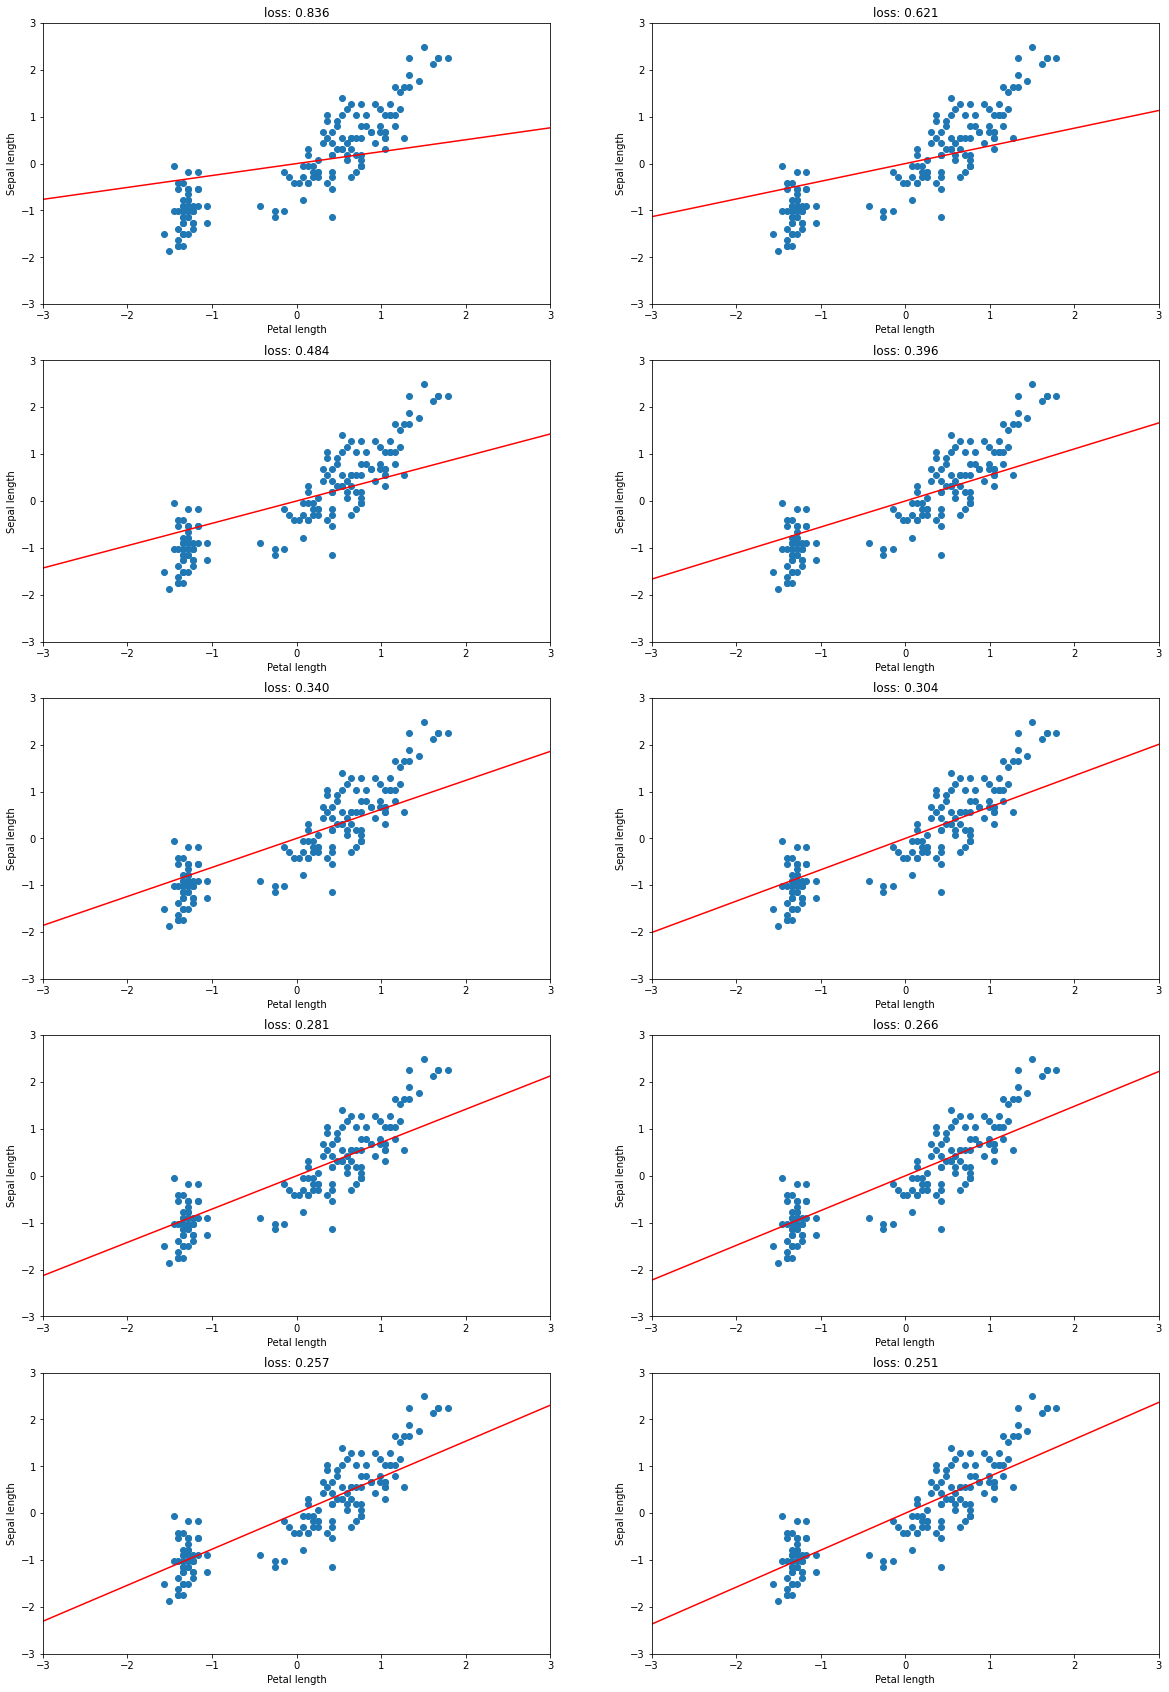

In [65]:
fig, axs = plt.subplots(
    nrows=EPOCHS // 2,
    ncols=2,
    figsize=(20, 30)
)

L_arr = np.empty(EPOCHS)
for e in epochs:
    e_n = e["epoch"]
    w = float(e["params"][0])
    b = float(e["params"][1])
    L = e["loss"]
    
    L_arr[e_n] = L
    
    i, j = divmod(e_n, 2)
    
    x_line = np.array([-3, 3])
    y_line = x_line * w + b
    axs[i, j].plot(x_line, y_line, "r")
    
    axs[i, j].scatter(
        df_train["petal_length"],
        df_train["sepal_length"]
    )
    
    axs[i, j].set_xlim([-3, 3])
    axs[i, j].set_ylim([-3, 3])
    axs[i, j].title.set_text(f"loss: {L:.3f}")
    axs[i, j].set_xlabel("Petal length")
    axs[i, j].set_ylabel("Sepal length")
    

## Visualize the change in loss epoc-by-epoch

Text(0, 0.5, 'loss')

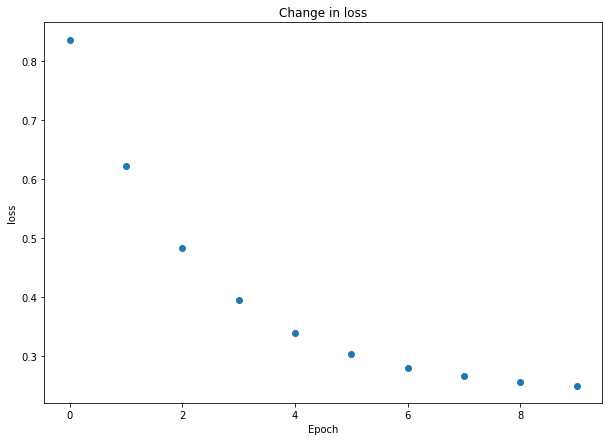

In [54]:
plt.figure(figsize=(10, 7))

plt.scatter(
    np.array(range(EPOCHS)),
    L_arr
)
plt.title("Change in loss")
plt.xlabel("Epoch")
plt.ylabel("loss")